# HW 4

In [7]:
import numpy as np
import pandas as pd
import inst
import fmt
from swap import Swap, priceSwap
import lin
import matplotlib.pyplot as plt

## Problem 1
Implement the thomas algorithm for solving tri-diagonal linear systems

In [1]:
import numpy as np


def tridiag(A, y):
    new_A = A.copy()
    new_y = y.copy()

    for i in range(1, len(A)):
        a_i = new_A[i, i-1]
        b_i = new_A[i-1, i-1]
        m = a_i/b_i
        new_A[i, i] -= (m*new_A[i-1, i])
        new_y[i] -= new_y[i-1]*m

    x = np.zeros(len(new_y))
    x[-1] = new_y[-1]/new_A[-1,-1]

    for i in range(len(x)-2, -1, -1):
        x[i] = (new_y[i] - new_A[i, i+1]*x[i+1]) / new_A[i, i]

    return x


A = np.array([
    np.array([2.04, -1, 0, 0]),
    np.array([-1, 2.04, -1, 0]),
    np.array([0, -1, 2.04, -1]),
    np.array([0, 0, -1, 2.04]),
])
y = np.array([40.8, 0.8, 0.8, 200.8])
tridiag(A, y)

array([ 65.96983437,  93.77846211, 124.53822833, 159.47952369])

## Problem 2

In [31]:
import numpy as np
import pandas as pd

mats = np.array([1, 2, 3, 5, 7, 10, 12, 15, 20, 25])*1.
par = np.array([.042, .043, .047, .054, .057, .06, .061, .059, .056, .0555])

df_swap = pd.DataFrame(np.array([par]).T*100,
                       columns=["Par Rate (%)"], 
                       index=map(lambda m: '%dY' % m, mats))

def disc(t):
    return np.exp(-0.04*t)


def y2pv(swap, curve):
    discf = lambda ts: np.exp(-curve(ts))
    return priceSwap(swap, discf)


insts = [Swap(m, c, 2) for m, c in zip(mats, par)]
benchmarks = {i: y2pv(i, disc) for i in insts}
df_swap.T

,1Y,2Y,3Y,5Y,7Y,10Y,12Y,15Y,20Y,25Y
Par Rate (%),4.2,4.3,4.7,5.4,5.7,6.0,6.1,5.9,5.6,5.55


### Part 1
Explain what is the purpose of the `+1e-6` in the first line of the `priceSwap` function

If we do not include `1e6`, then the last coupon payment will not be taken into account. Adding any value less than $\frac{1}{n}$, where $n$ is the number of coupons per year, will have the same effect.

### Part 2
Use the market data above to boostrap the IR curve by interpolating the cumulative yield $y(t)=−log⁡(b(t))$ with tension spline, where $b(t)$ is the discount factor (i.e., the price of risk free zero coupon bonds). After bootstraping the curve, re-price the benchmark instruments using the bootstrapped curve, and compute the L-2 norm of the absolute pricing errors. Show how the pricing error of the bootstraped curve depend on the tension parameter $\lambda$.

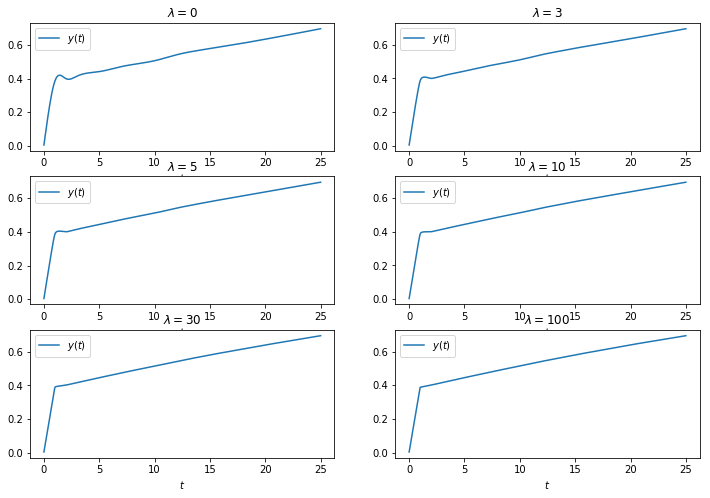

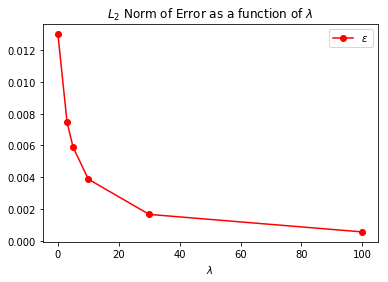

In [50]:
def plotboot(tsit, lbd, ax, tagsf) :
    df = pd.DataFrame({'$t$':xs}).set_index(['$t$'])
    
    df['$y(t)$'] = tsit(xs) 
    
    df.plot(ax=ax, secondary_y=[tagsf[0][0]], title='$\\lambda=%.f$' % lbd)


lbds = [0, 3, 5, 10, 30, 100]
xs = np.arange(.01, 25, .01)
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[12, 8])

errors = []

for lbd, ax in zip(lbds, axes.flatten()) :
    tsit, e = inst.iterboot(benchmarks, priceSwap, lbd=lbd, x0=0, its=1)
    plotboot(tsit, lbd, ax, tagsf)
    errors.append(np.linalg.norm(e, 2, 1)[0])

errors = pd.DataFrame({'$\\lambda$':lbds, '$\\epsilon$': errors}).set_index('$\\lambda$')
error_plot = errors.plot(title='$L_2$ Norm of Error as a function of $\\lambda$', style='ro-')


As $\lambda$ approaches $\infty$, the bootstrapped curve becomes a piecewise flat bootstrap. There is no reason at all for a piecewise flat bootstrap curve to not perfectly represent the points it is interpolating, in contrast to $\lambda=0$, when fitting the first and second derivatives may cause points to shift.

### Part 3
Using the iteration technique to reduce the $L_2$ norm of the error below 1bps, how many iteration is needed for the error to go below 1bps?

,$\epsilon_{m=0.0}$,$\epsilon_{m=0.25}$,$\epsilon_{m=0.5}$,$\epsilon_{m=0.75}$,$\epsilon_{m=1.0}$
Iterations $\lambda=0$,,,,,
1,0.01301,0.01301,0.01301,0.01301,0.01301
2,0.00006,0.00323,0.00649,0.00975,0.01301
3,0.00000,0.00080,0.00324,0.00731,0.01301
4,0.00000,0.00020,0.00162,0.00548,0.01301
5,0.00000,0.00005,0.00081,0.00410,0.01301
6,0.00000,0.00001,0.00040,0.00308,0.01301
7,0.00000,0.00000,0.00020,0.00231,0.01301
8,0.00000,0.00000,0.00010,0.00173,0.01301
9,0.00000,0.00000,0.00005,0.00129,0.01301


,$\epsilon_{m=0.0}$,$\epsilon_{m=0.25}$,$\epsilon_{m=0.5}$,$\epsilon_{m=0.75}$,$\epsilon_{m=1.0}$
Iterations $\lambda=3$,,,,,
1,0.00747,0.00747,0.00747,0.00747,0.00747
2,0.00002,0.00186,0.00373,0.00560,0.00747
3,0.00000,0.00046,0.00186,0.00420,0.00747
4,0.00000,0.00012,0.00093,0.00315,0.00747
5,0.00000,0.00003,0.00046,0.00236,0.00747
6,0.00000,0.00001,0.00023,0.00177,0.00747
7,0.00000,0.00000,0.00012,0.00133,0.00747
8,0.00000,0.00000,0.00006,0.00099,0.00747
9,0.00000,0.00000,0.00003,0.00075,0.00747


,$\epsilon_{m=0.0}$,$\epsilon_{m=0.25}$,$\epsilon_{m=0.5}$,$\epsilon_{m=0.75}$,$\epsilon_{m=1.0}$
Iterations $\lambda=5$,,,,,
1,0.00588,0.00588,0.00588,0.00588,0.00588
2,0.00001,0.00147,0.00294,0.00441,0.00588
3,0.00000,0.00037,0.00147,0.00331,0.00588
4,0.00000,0.00009,0.00073,0.00248,0.00588
5,0.00000,0.00002,0.00037,0.00186,0.00588
6,0.00000,0.00001,0.00018,0.00139,0.00588
7,0.00000,0.00000,0.00009,0.00105,0.00588
8,0.00000,0.00000,0.00005,0.00078,0.00588
9,0.00000,0.00000,0.00002,0.00059,0.00588


,$\epsilon_{m=0.0}$,$\epsilon_{m=0.25}$,$\epsilon_{m=0.5}$,$\epsilon_{m=0.75}$,$\epsilon_{m=1.0}$
Iterations $\lambda=10$,,,,,
1,0.00388,0.00388,0.00388,0.00388,0.00388
2,0.00000,0.00097,0.00194,0.00291,0.00388
3,0.00000,0.00024,0.00097,0.00218,0.00388
4,0.00000,0.00006,0.00048,0.00163,0.00388
5,0.00000,0.00002,0.00024,0.00123,0.00388
6,0.00000,0.00000,0.00012,0.00092,0.00388
7,0.00000,0.00000,0.00006,0.00069,0.00388
8,0.00000,0.00000,0.00003,0.00052,0.00388
9,0.00000,0.00000,0.00002,0.00039,0.00388


,$\epsilon_{m=0.0}$,$\epsilon_{m=0.25}$,$\epsilon_{m=0.5}$,$\epsilon_{m=0.75}$,$\epsilon_{m=1.0}$
Iterations $\lambda=30$,,,,,
1,0.00166,0.00166,0.00166,0.00166,0.00166
2,0.00000,0.00041,0.00083,0.00124,0.00166
3,0.00000,0.00010,0.00041,0.00093,0.00166
4,0.00000,0.00003,0.00021,0.00070,0.00166
5,0.00000,0.00001,0.00010,0.00052,0.00166
6,0.00000,0.00000,0.00005,0.00039,0.00166
7,0.00000,0.00000,0.00003,0.00030,0.00166
8,0.00000,0.00000,0.00001,0.00022,0.00166
9,0.00000,0.00000,0.00001,0.00017,0.00166


,$\epsilon_{m=0.0}$,$\epsilon_{m=0.25}$,$\epsilon_{m=0.5}$,$\epsilon_{m=0.75}$,$\epsilon_{m=1.0}$
Iterations $\lambda=100$,,,,,
1,0.00056,0.00056,0.00056,0.00056,0.00056
2,0.00000,0.00014,0.00028,0.00042,0.00056
3,0.00000,0.00003,0.00014,0.00031,0.00056
4,0.00000,0.00001,0.00007,0.00023,0.00056
5,0.00000,0.00000,0.00003,0.00018,0.00056
6,0.00000,0.00000,0.00002,0.00013,0.00056
7,0.00000,0.00000,0.00001,0.00010,0.00056
8,0.00000,0.00000,0.00000,0.00007,0.00056
9,0.00000,0.00000,0.00000,0.00006,0.00056


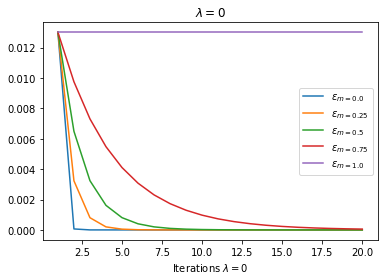

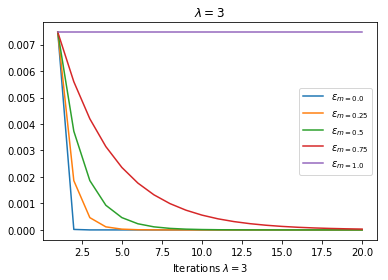

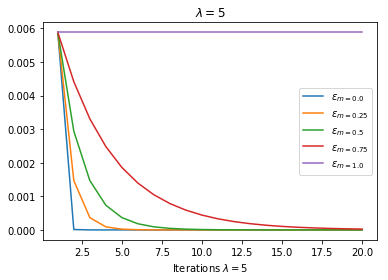

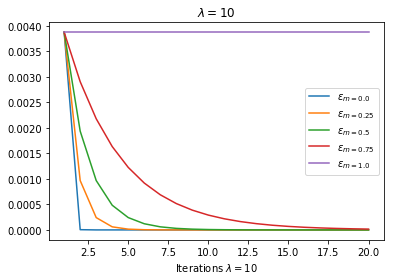

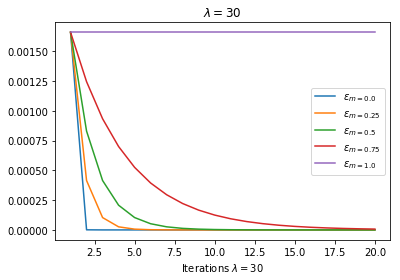

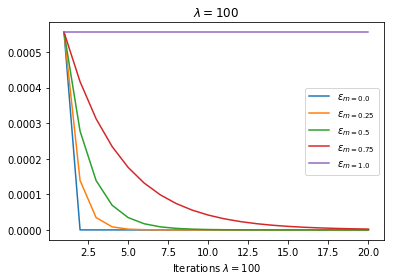

In [68]:
its = 20
for lbd in [0, 3, 5, 10, 30, 100]:
    index = 'Iterations $\\lambda=%d$'%lbd
    data = {index: np.arange(1, its+1, 1)}

    for mixf in np.arange(1, -0.1, -0.25):
        tsit, e = inst.iterboot(benchmarks, priceSwap, lbd=lbd, x0=0, its=its, mixf=mixf)
        data['$\\epsilon_{m=%s}$'%mixf] = np.linalg.norm(e, 2, 1)

    data = pd.DataFrame(data).set_index(index)
    axes = data.plot(title="$\\lambda=%d$"%lbd)
    fmt.displayDF(data, "5f")

Error elimination depends on the degree of mixing. Obviously, when we reject the new curve $m=1$, the error remains constant since new iterations are thrown out. When $0 \leq m < 1$, however, error decreases. The above tables will suffice for explaining $\lambda > 0$, but for $\lambda = 0$, we see the maximum number of iterations required: higher values of $\lambda$ will lead to fewer required iterations.

When $m=0$, we hit less than 1 bp of error by the second iteration.

When $m=0.25$, we require 5 iterations.

When $m=0.50$, we require 9 iterations.

When $m=0.75$, we require 19 iterations.

### Part 4
From the curve built in the previous step, compute both the $y(t)$ and the instantaneous forward rate $f(t) = - \frac{1}{b(t)}\frac{db(t)}{dt} = \frac{dy(t)}{dt}$ and show how their shapes change with the tension parameter $\lambda$. In addition, compare the changes in the instantaneous forward rates with 1bps change in the 5Y par swap rate. You can use the `deriv()` method in the Tension spline class.

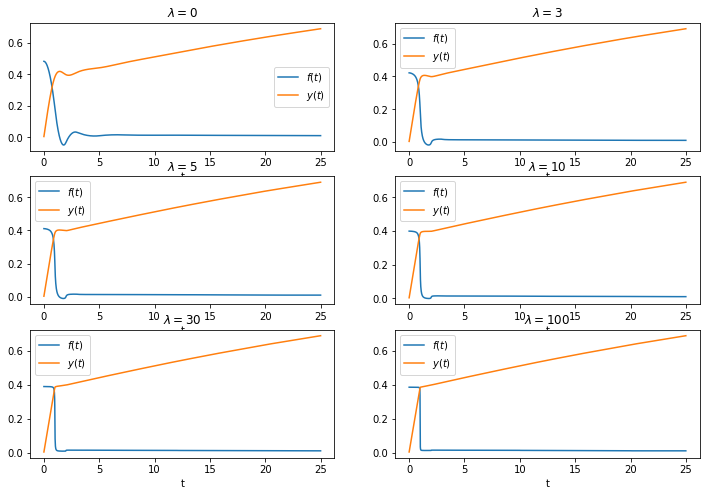

In [71]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[12, 8])
xs = np.arange(.01, 25, .01)
for lbd, ax in zip([0, 3, 5, 10, 30, 100], axes.flatten()):
    data = {'t': xs}
    tsit, e = inst.iterboot(benchmarks, priceSwap, lbd=lbd, x0=0, its=19, mixf=0.75)
    data['$y(t)$'] = tsit(xs)
    data['$f(t)$'] = tsit.deriv(xs)
    pd.DataFrame(data).set_index('t').plot(ax=ax, title="$\\lambda=%d$"%lbd)

The forward rate curve becomes increasingly discontinuous as $\lambda$ increases. We expect this -- as $\lambda$ increases, the cumulative yield interpolation becomes a piece-wise defined linear function, at which point, we would expect full discontinuity in its first derivative

### Part 5
Repeat the previous step, but directly interpolating the forward rates $f(t)$, and comment on whether it is suitable in practice.

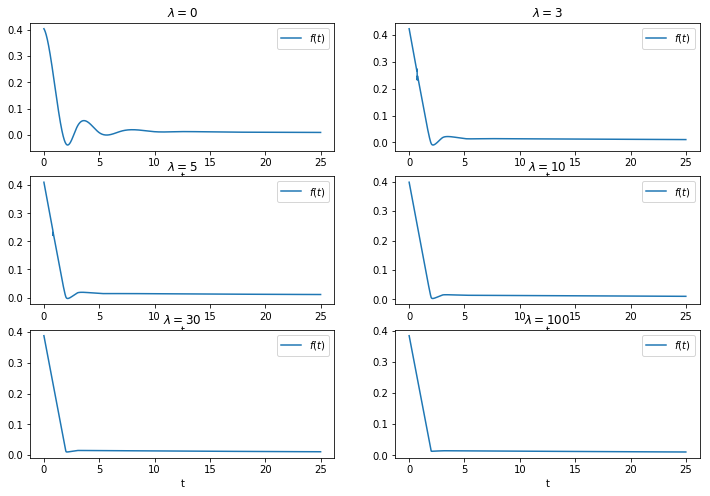

In [76]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=[12, 8])
xs = np.arange(.01, 25, .01)
for lbd, ax in zip([0, 3, 5, 10, 30, 100], axes.flatten()):
    tsit, e = inst.iterboot(benchmarks, priceSwap, lbd=lbd, x0=0, its=19, mixf=0.75)
    ys = tsit.deriv(mats)
    curve = lin.RationalTension(lbd)
    curve.build(mats, ys)
    data = {
        't': xs,
        '$f(t)$': curve(xs),
    }
    pd.DataFrame(data).set_index('t').plot(ax=ax, title="$\\lambda=%d$"%lbd)

This is fairly clearly off - we expect to see a discontinuous curve of $f(t)$ as $\lambda \rightarrow 0$. However, this is not happening, which tells us that interpolation of the forward curves is not reflective of reality.